In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import os
from PIL import Image
import arviz as az
from tools import img_slice
from Horseshoe_img_comp import Horseshoe_img_comp
import pickle
from matplotlib.pyplot import figure

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


# Image compression via the Horseshoe

In this example, we will compress an image using a jpeg-inspired process. The steps are the following:  

- First slice the image in 5 x 5 blocks, in a jpeg fashion. Empirically, this block size seemed to be a good tradeoff as MCMC computations get slower with increasing block sizes. Having a small block size also puts more weight on the prior, since as a regression problem the block size can be considered as the number of observations. Therefore, it ensures sparse results. The block size is denoted by $D = 5$.  

- Then, the mean component is dealt with appart. Indeed, the mean component being often higher than others in real-world images, we noticed that keeping it often yielded results that were "too sparse" (the output coefficients were mostly zero except for the mean component). For a single block:  
    - Let $y_{flat}$ be a flattened block
    - $y_{AC} = y_{flat} - \text{mean}(y_{flat})\mathbb{1}_{D^2}$
    - Then, let us remove the first line of the intensity basis matrix $\Psi$ (which corresponds to the mean component). This gives $\Psi_{1:}$.
    - Find a pseudo-sparse vector $\theta$ of size $D^2 - 1$ which approximately solves: $y_{AC} = \theta^T \Psi_{1:}$. This is achieved via the Horseshoe.  
    - Put less significant values of $\theta$ to 0 to build $\theta_{sparse}$. For instance, keep the 5 most significant ones.
    - Finally: $y_{flat}^{comp} = \theta_{sparse}^T \Psi_{1:} + \text{mean}(y_{flat})\mathbb{1}_{D^2}$  
    
<br/>

- Putting the blocks together forms the compressed image. One only needs to store the non-zero components of the $\theta$ of every block instead of its 5 x 5 values. As in a usual Jpeg process, one could then entropy-encode these coefficients.

In [2]:
block_size = 5 # e.g. 8 means that that 8 x 8 blocks will be considered like in jpeg.

## Building an intensity basis matrix

Using inverse DCT, let us first built a basis of matrices that we can then use to create any block of intensity $\in$ [0, 255].

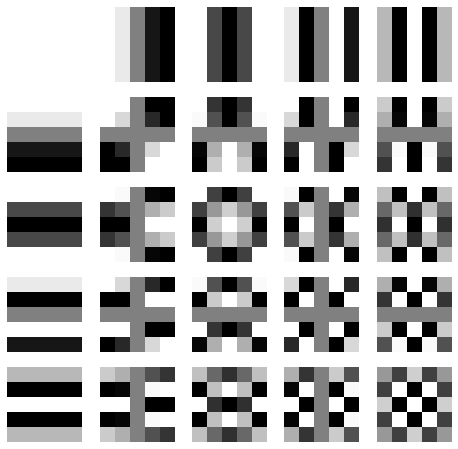

In [3]:
hic = Horseshoe_img_comp(block_size)
hic.display_intensity_basis()

This basis is made so that any 5 x 5 block of integers $\in$ [0, 255] can be described as linear combination of these basis blocks.

Let us write this basis as a matrix by flattening every of these basis blocks and putting them as lines of a 25 x 25 matrix:

[]

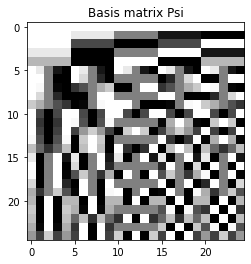

In [4]:
intensity_basis = hic.compute_basis_intensity_matrix()
plt.imshow(intensity_basis, cmap = "gray", vmin=0, vmax=255)
plt.title("Basis matrix Psi")
plt.plot()

Let $y$ be an image, and $y_{flat}$ its flattened version. Let $\theta$ represent some unknown coefficients (1D vector, same size as $y_{flat}$).   
$y_{flat}$ can be written:   
$y_{flat}$ = $\theta^T \Psi$  

With $\Psi$ the Basis matrix we have just defined.

Let us remove the first line of $\Psi$, the mean component. It will be dealt with apart.

In [5]:
intensity_basis = intensity_basis[1:] # The average component (the first one) is dealt with apart

## Image compression

Let us import an image from the UCID dataset (uncompressed images in TIFF format), and slice it in 5 x 5 blocks.

In [6]:
tif_pil = Image.open('images/ucid00652_small.tif').convert('L') # Greyscale image
tif_arr = np.array(tif_pil)
dim_x, dim_y = tif_arr.shape
tif_arr = tif_arr[:dim_x - dim_x % 5,:dim_y - dim_y % 5] # Making sure the image has dimensions multiples of block_size
print(tif_arr.shape)

(35, 35)


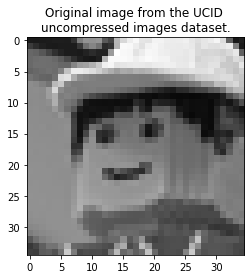

In [16]:
plt.imshow(tif_arr, cmap="gray", vmin=0, vmax=255)
plt.title("Original image from the UCID \nuncompressed images dataset.")
plt.show()

In [8]:
height_in_blocks = int(tif_arr.shape[0] / block_size)
width_in_blocks = int(tif_arr.shape[1] / block_size)

Slicing the image into 5 x 5 blocks:

In [9]:
sliced_img = img_slice(tif_arr, 5)
compressed_blocks = []
all_coefs_save = []

Compression takes a lot of time. Therefore, it is computed line of blocks by line of blocks (so that we do not need to start over if an error occurs). Since pymc3 warning cannot be easily turned off, it affects the readability of the code. The file `Image_comp_computations.ipynb` includes these steps. Here, this file only loads the compressed blocks from saved pickle files.

In [10]:
### Loading compressed blocks from saved pickle files.
compressed_blocks = []
for line_nb in range(1,8):
    with open(f"saves/compressed_blocks_line{line_nb}.pckl", "rb") as save_file:
        p = pickle.Unpickler(save_file)
        compressed_line = p.load()
    compressed_blocks.append(np.hstack(compressed_line))

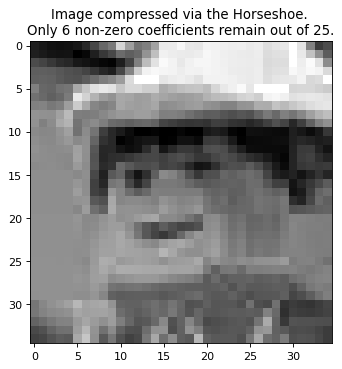

In [13]:
### Displaying the compressed image
figure(figsize=(5, 5), dpi=80)
compressed_img = np.vstack(compressed_blocks)

plt.imshow(compressed_img, vmin=0, vmax=255, cmap="gray")
plt.title("Image compressed via the Horseshoe. \nOnly 6 non-zero coefficients remain out of 25.")
plt.show()